UNNP-EIT-Demo

Deep Plug-and-play Prior for Enhanced Electrical Impedance Tomography

Please implement the DPnPP-EIT code yourself based on this code and paper.

Author: Zekun Chen (chenzk806@nenu.edu.cn, 229800776@qq.com)

d:\ProgramData\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(208, 3228)
(3228, 3)
(64, 64)
(3228, 1)
(3228,)
[1. 1. 1. ... 1. 1. 1.]
89.07141441983457


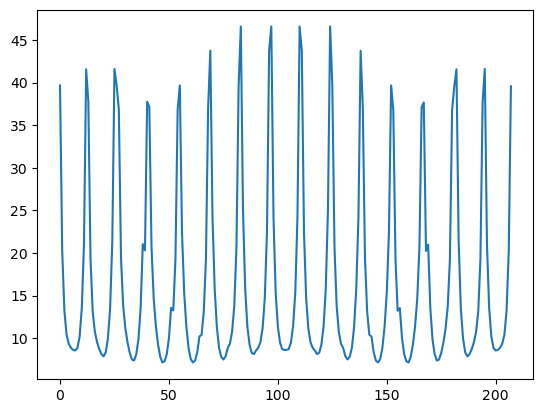

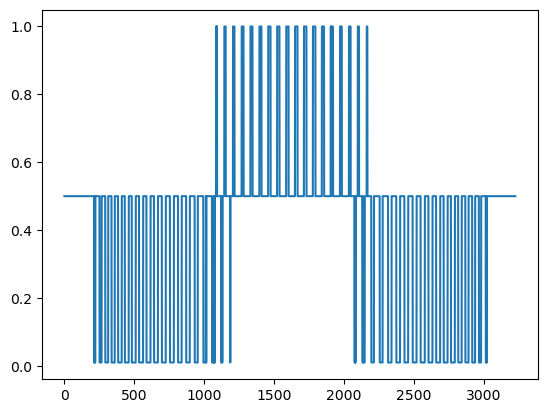

torch.Size([208, 3228])
torch.Size([208])
V torch.Size([208])


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os

import numpy as np
from models import *

import torch
import torch.optim

import torch.optim as optim
from torchviz import make_dot

from tensorboardX import SummaryWriter 


# from skimage.measure import compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
# from utils.denoising_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from scipy.io import savemat
import matlab
import matlab.engine

eng = matlab.engine.start_matlab()
eng.addpath('mat')#Add MATLAB function path

#Delete the element at position 0
def remove_zeros(lst):
    return np.array([
        remove_zeros(item) if isinstance(item, list) else item
        for item in lst
        if item != 0
    ])

def min_max_numpy(vector):
    min_val = np.min(vector)
    max_val = np.max(vector)
    normalized_vector = (vector - min_val) / (max_val - min_val)
    return normalized_vector

def min_max_torch(vector):
    min_val = torch.min(vector)
    max_val = torch.max(vector)
    normalized_vector = (vector - min_val) / (max_val - min_val)
    return normalized_vector

St = eng.load('S1.mat')
S=np.array(St['S'])

MMt = eng.load('MM1.mat')
MM=np.array(MMt['MM'])

tranpt = eng.load('tranp1.mat')
tranp=np.array(tranpt['tranp'])
tranp1t = eng.load('tranp256.mat')
tranp1=np.array(tranp1t['tranp1'])

PMt = eng.load('PM.mat')
PM=np.array(PMt['PM'])

print(S.shape)
print(MM.shape)
print(tranp.shape)

dataht = eng.load('.\data_pho\lung_g.mat')
datah=dataht['lung_g']
datah=np.array(datah)
print(datah.shape)

sig=np.squeeze(datah)
print(sig.shape)
print(sig)

sig=np.round(sig, 2)

#Simulated conductivity data
sig[sig == 1]=0.5
sig[sig == 0.2]=0.01
sig[sig == 0.1]=0.01
sig[sig == 2]=1

# Generate boundary voltage based on conductivity and Jacobian matrix
inh_data_norm=np.matmul(S,sig)*1
homg_data_norm=np.matmul(S,sig*0+1)*1

# dV=inh_data_norm/max(inh_data_norm)*max(homg_data_norm)
dV=inh_data_norm
V=inh_data_norm

print(max(homg_data_norm))
plt.figure(dpi=100)
plt.plot( np.linspace(0, 207, 208),dV)
# plt.axis('off') 
plt.show()

plt.figure(dpi=100)
plt.plot( np.linspace(0, 3227, 3228),sig)

plt.show()

dV = torch.from_numpy(dV)
V = torch.from_numpy(V)
J = torch.from_numpy(S)

print(J.shape)
print(dV.shape)
print("V",V.shape)




In [2]:
tranp = torch.from_numpy(tranp)
tranp1 = torch.from_numpy(tranp1)
PM = torch.from_numpy(PM)
tranp = tranp.type(dtype)
tranp1 = tranp1.type(dtype)
J = J.type(dtype)
dV = dV.type(dtype)
V = V.type(dtype)
PM = PM.type(dtype)

In [3]:
def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []
    
    for opt in opt_over_list:
    
        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'
            
    return params

In [ ]:
"""-------------------------------------------------------------------
                      Custom display function
-------------------------------------------------------------------"""
def P(A, PM):
    sigma = torch.matmul(PM,A)
    return sigma

def U(sig,J):
    v=torch.matmul(J,sig)
    return v

def Image_plot(Zs):
    ZZ0 = torch.reshape(Zs, (64, 64))
    ZZ = ZZ0.detach().cpu().numpy()
    plt.figure(dpi=300,figsize=(2,2))
    plt.imshow(ZZ,cmap='jet')#,cmap='RdBu' , interpolation='spline16'
    plt.colorbar()
    plt.axis('off') 
    plt.show()

"""-------------------------------------------------------------------
                             Model
-------------------------------------------------------------------"""
net = skip(
            1, 1, 
            num_channels_down = [16, 32, 64, 128, 256], 
            num_channels_up   = [16, 32, 64, 128, 256],
            num_channels_skip = [0, 2, 0, 2, 2], 
            upsample_mode='bilinear',
            need_sigmoid=True, need_bias=True, pad = 'reflection', act_fun='Swish')# LeakyReLU none Swish ELU

net = net.type(dtype)


ZZ = torch.zeros(64, 64)
ZZ=np.array(ZZ)
img_noisy_np=ZZ
ZZ=torch.from_numpy(ZZ)


Zt=min_max_torch(ZZ)
img_noisy_torch=Zt.type(dtype)

print (img_noisy_torch.shape)
print (img_noisy_torch)


# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

#------------------------------------------------------

torch.Size([64, 64])
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0')
Number of params: 2261663


torch.autograd.grad(
outputs,   # 计算图的数据结果张量--它就是需要进行求导的函数
inputs,   # 需要对计算图求导的张量--它是进行求导的变量
grad_outputs=None,   # 如果outputs不是标量，需要使用此参数
retain_graph=None,   # 保留计算图
create_graph=None,   # 创建计算图
allow_unused=False#inputs如果有不相关的变量，
#即不对Outputs产生贡献的，比如你随便乱写一个inputs在那里，会报错，
#改为True就不会报错，此时对这个垃圾inputs梯度为None返回。
)


torch.Size([1, 1, 64, 64])
tensor([[[[0.0311, 0.0367, 0.0571,  ..., 0.0210, 0.0295, 0.0504],
          [0.0542, 0.0296, 0.0387,  ..., 0.0544, 0.0308, 0.0294],
          [0.0597, 0.0643, 0.0132,  ..., 0.0020, 0.0387, 0.0337],
          ...,
          [0.0318, 0.0344, 0.0637,  ..., 0.0226, 0.0368, 0.0619],
          [0.0090, 0.0654, 0.0169,  ..., 0.0033, 0.0041, 0.0140],
          [0.0190, 0.0640, 0.0190,  ..., 0.0449, 0.0262, 0.0630]]]],
       device='cuda:0')


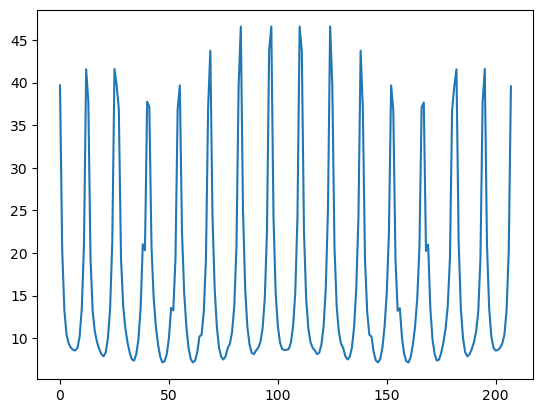

Starting optimization with ADAM


d:\ProgramData\anaconda3\envs\pytorch_gpu\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


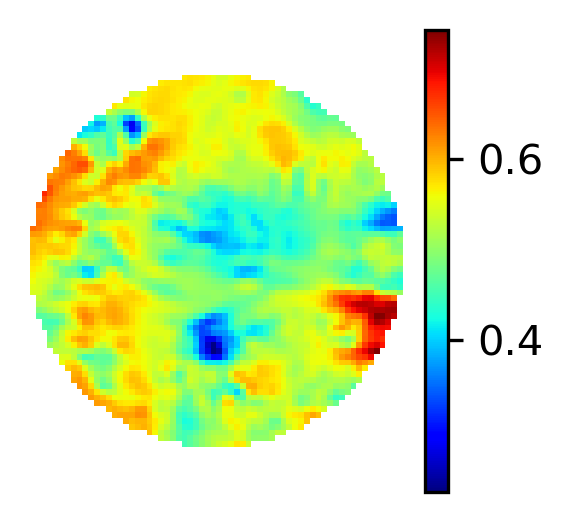

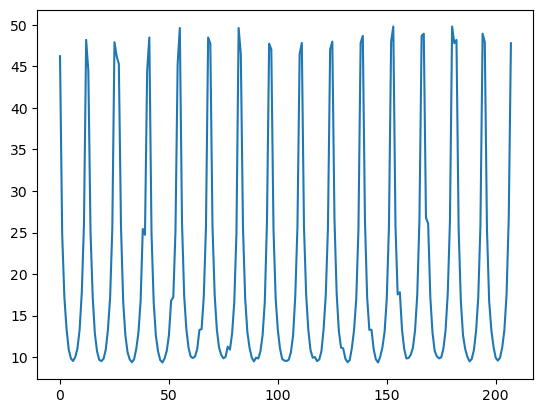

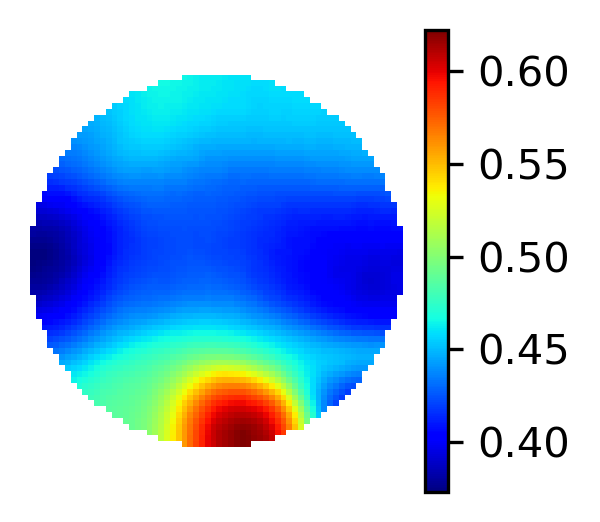

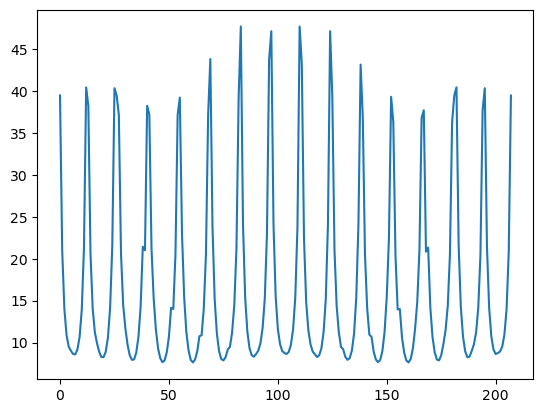

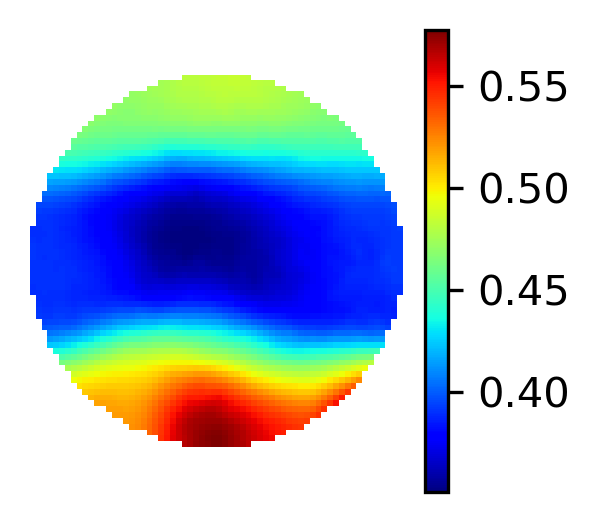

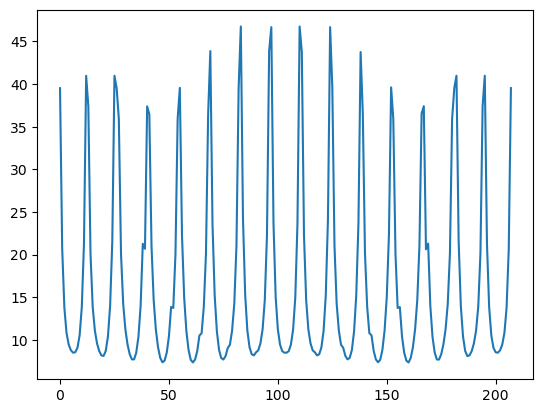

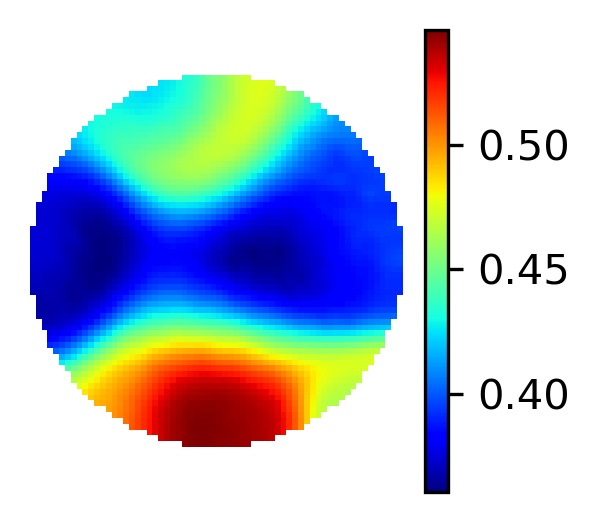

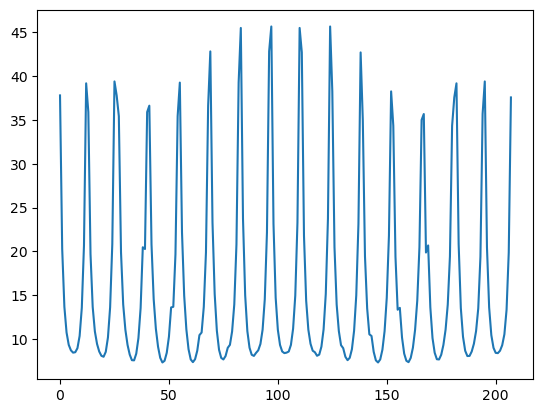

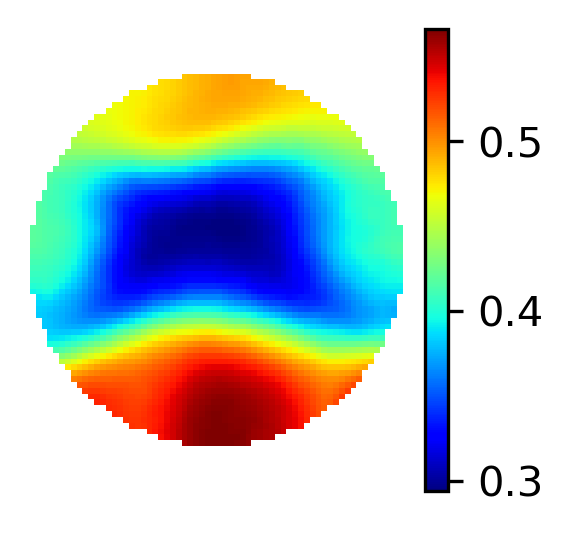

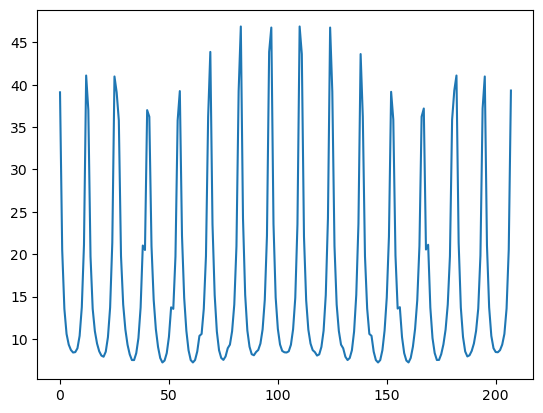

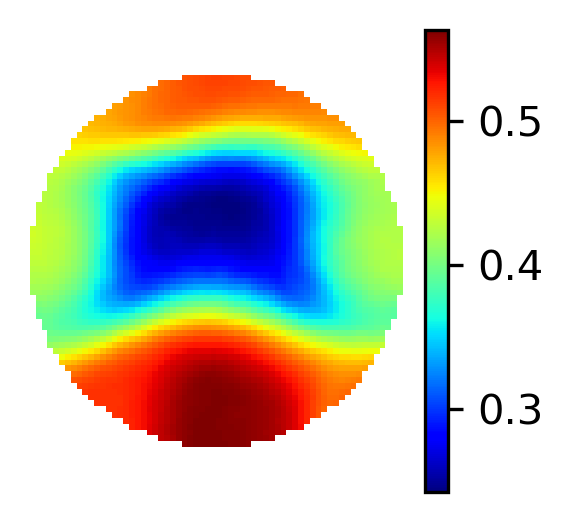

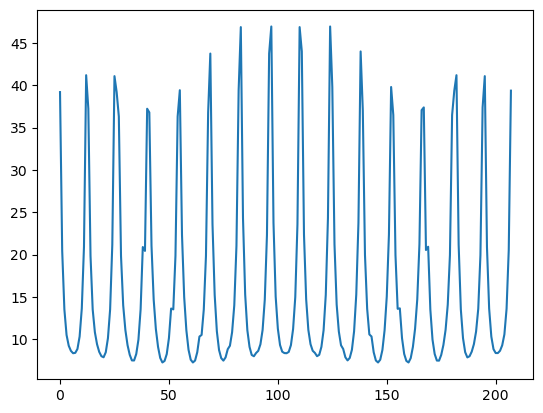

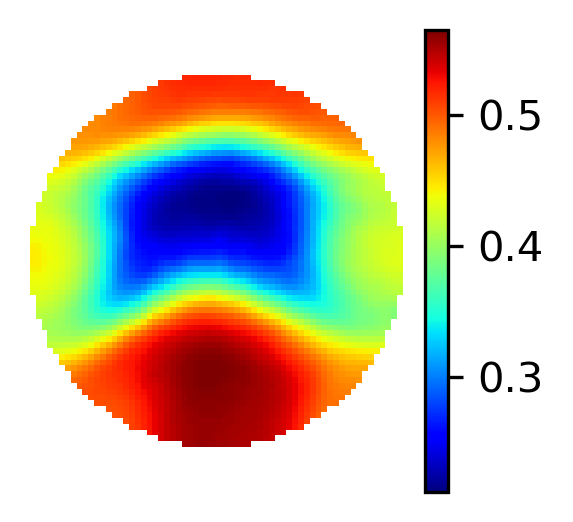

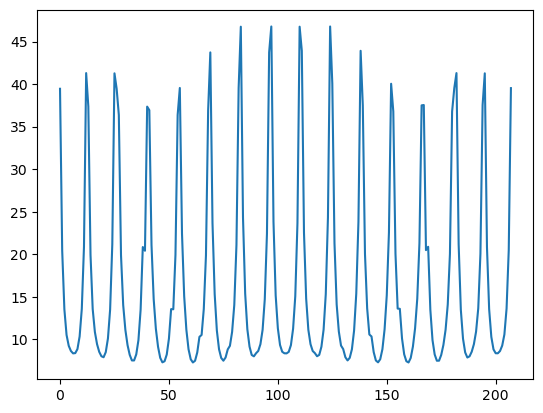

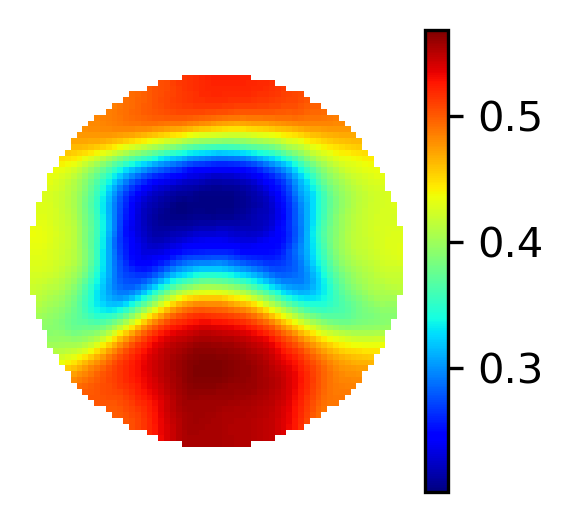

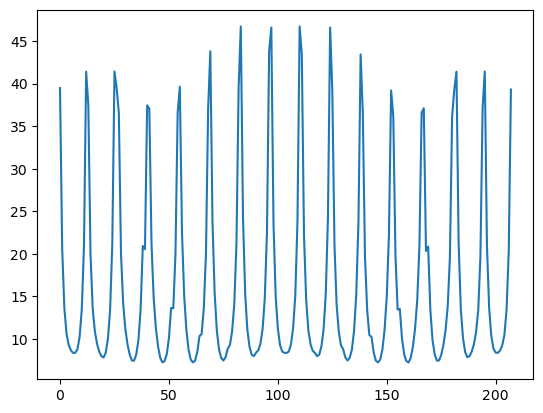

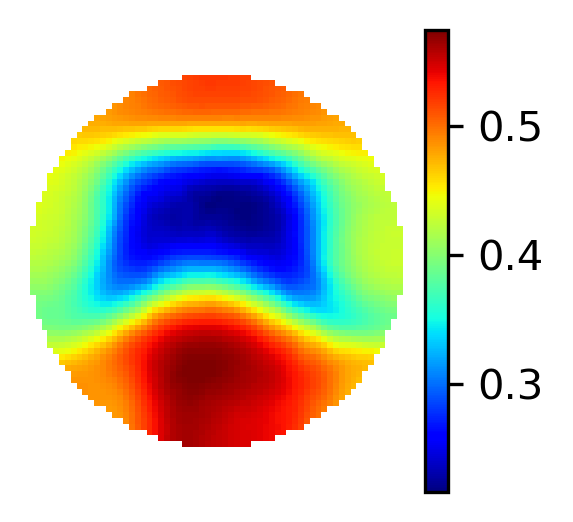

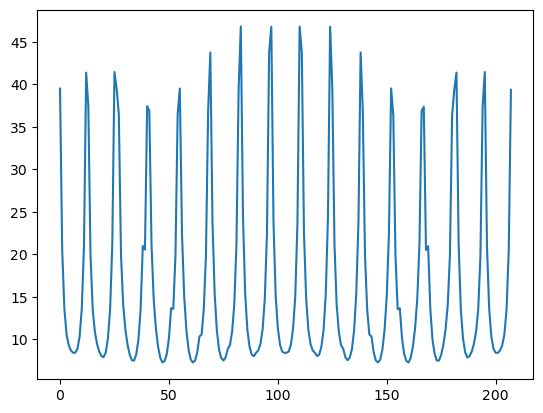

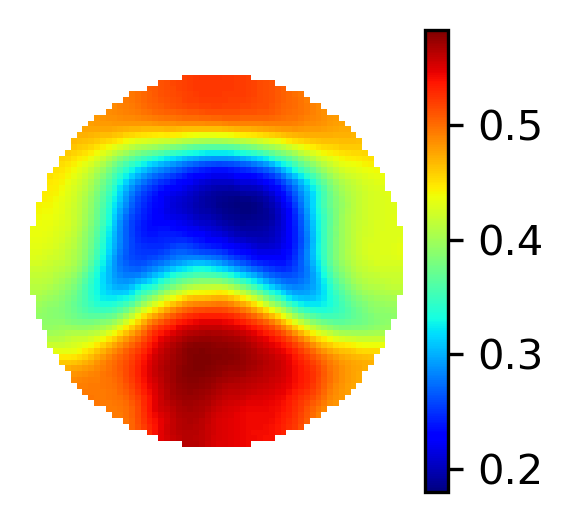

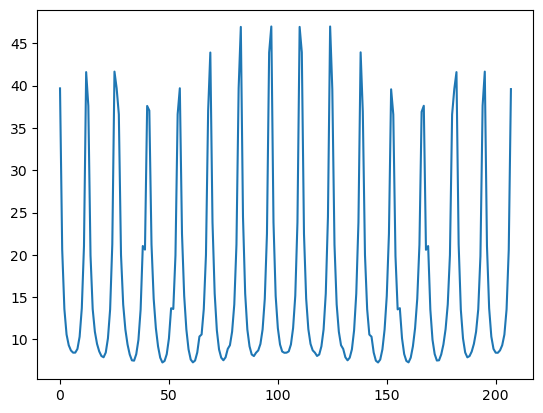

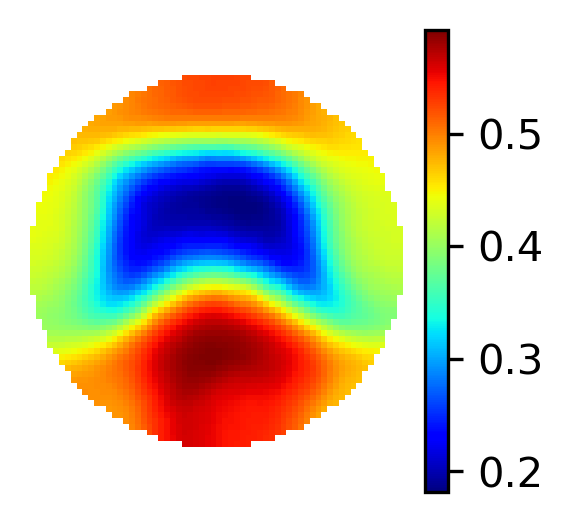

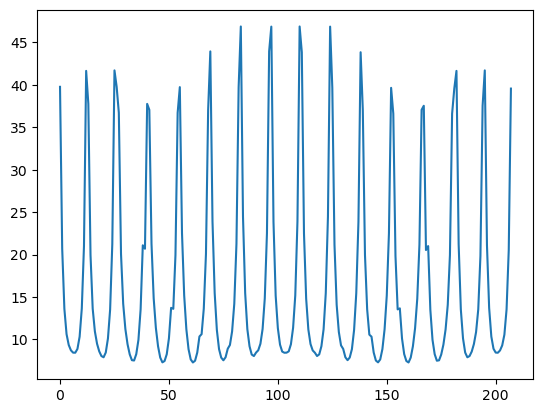

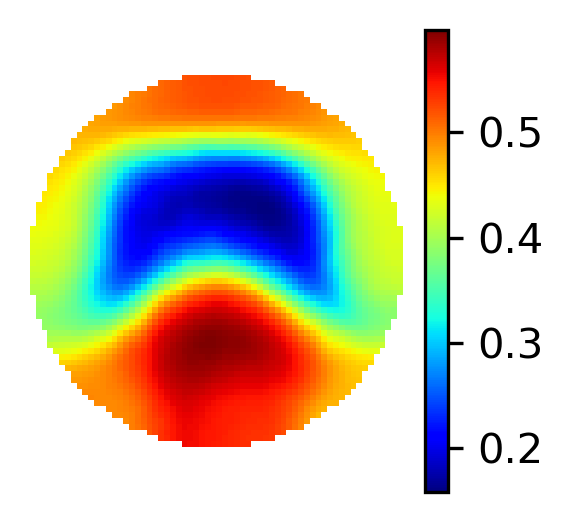

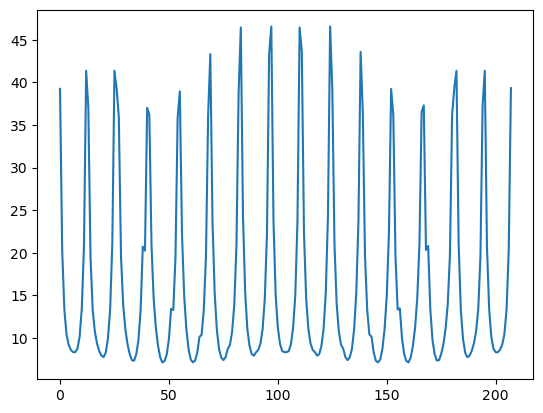

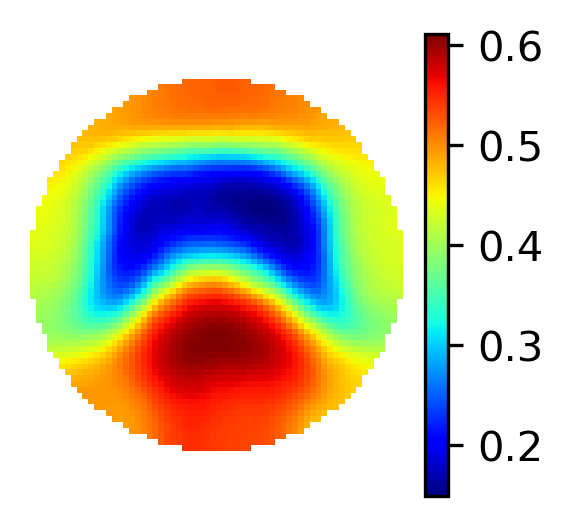

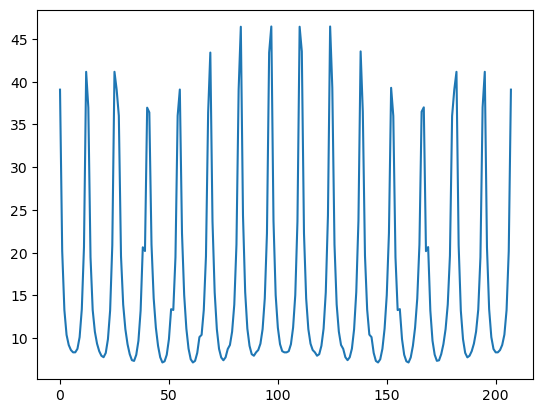

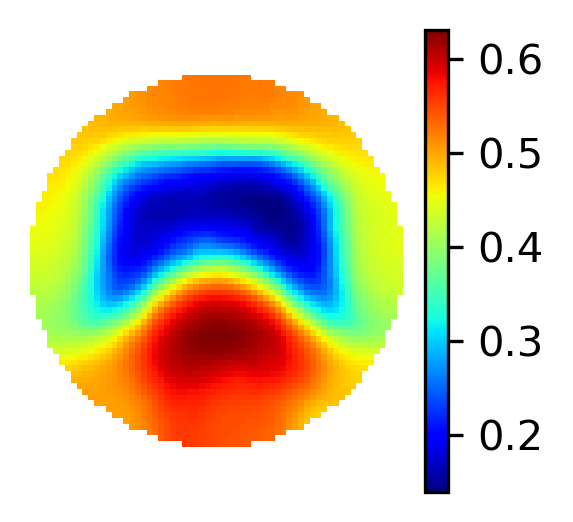

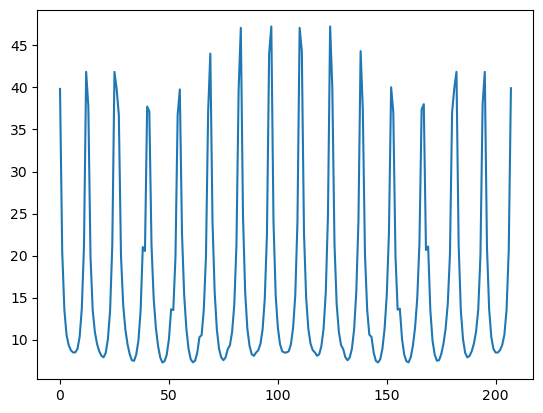

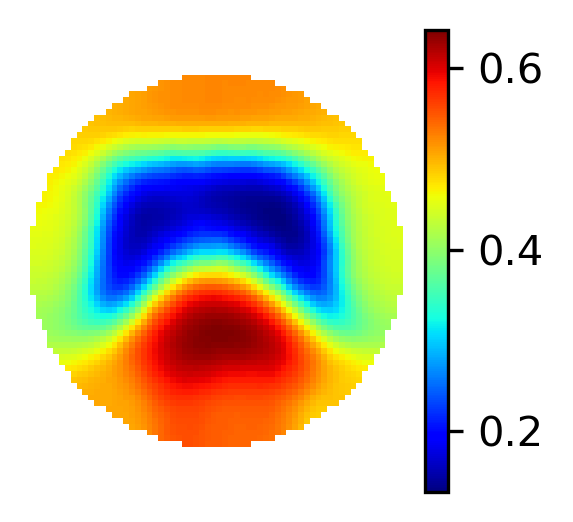

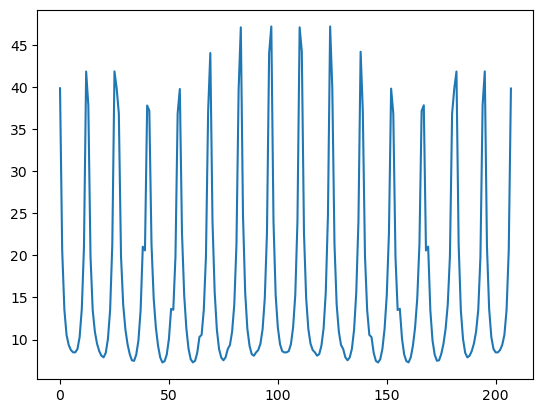

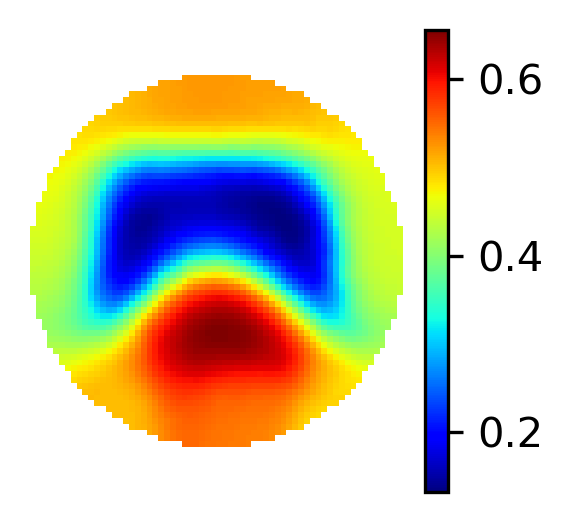

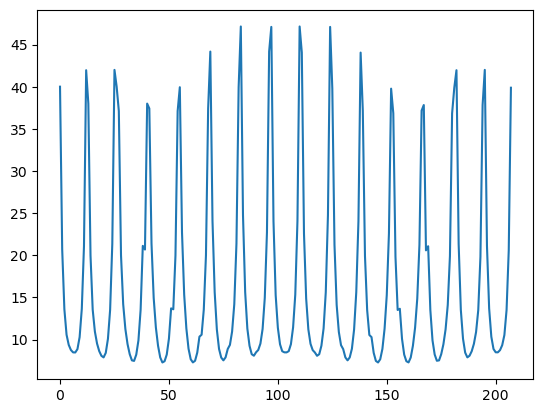

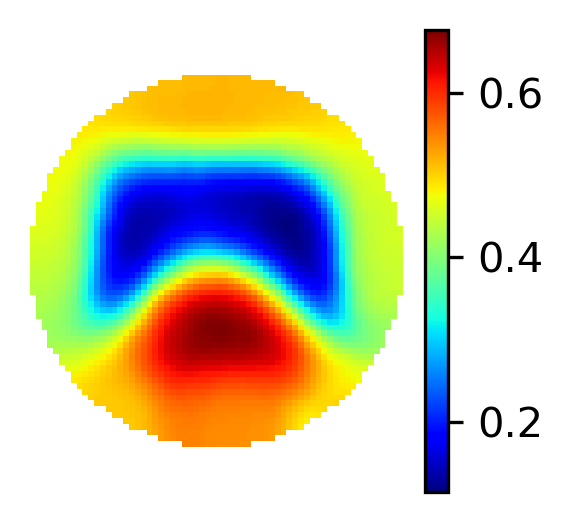

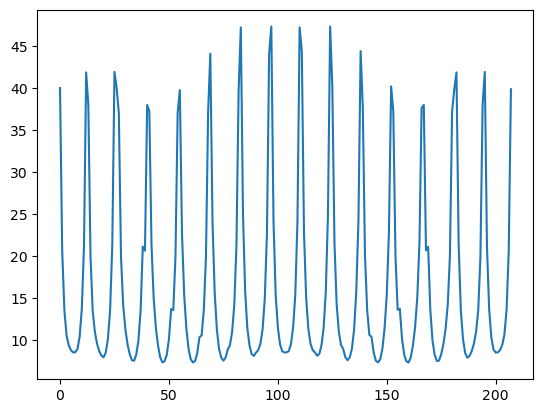

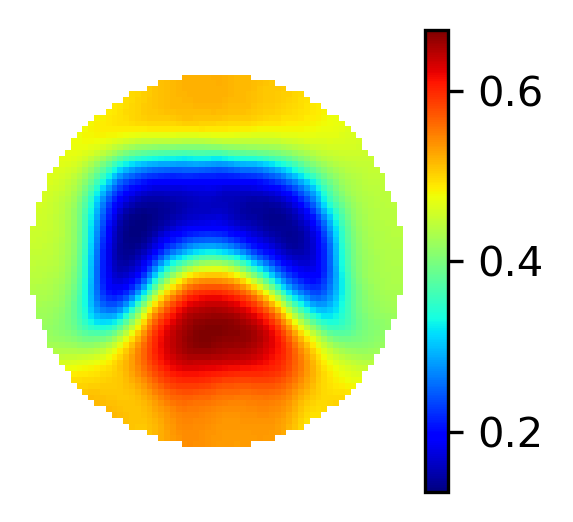

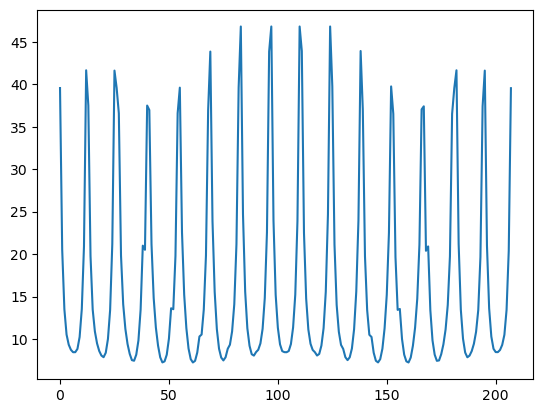

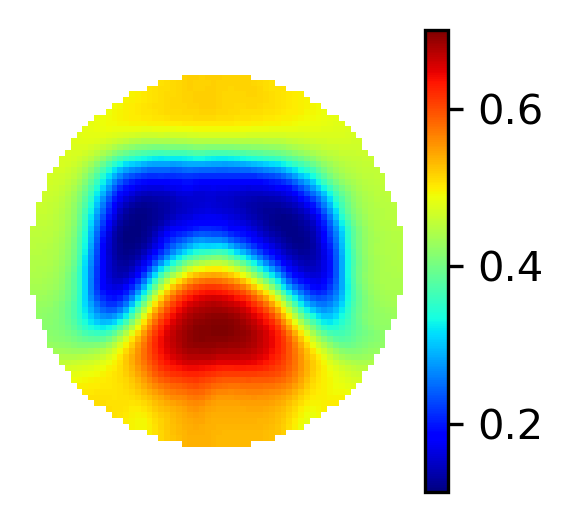

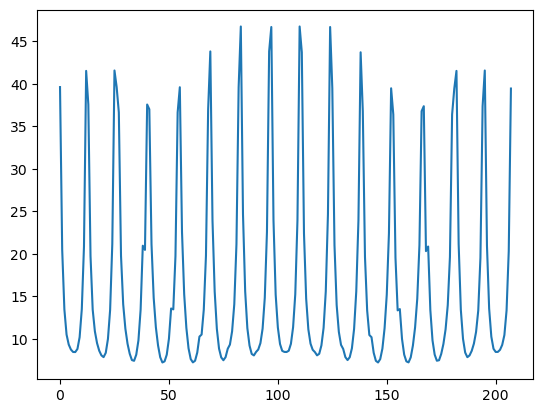

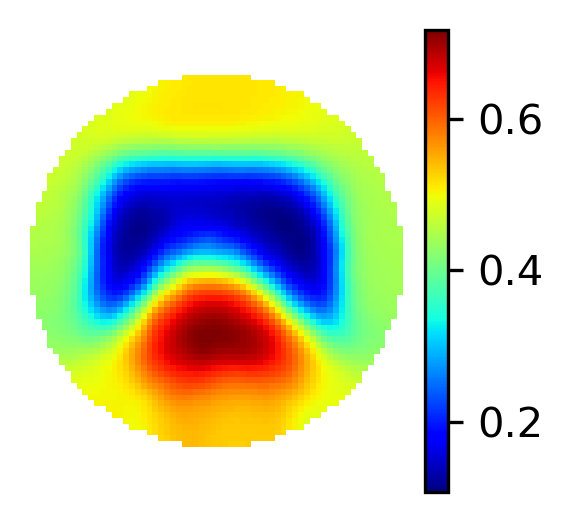

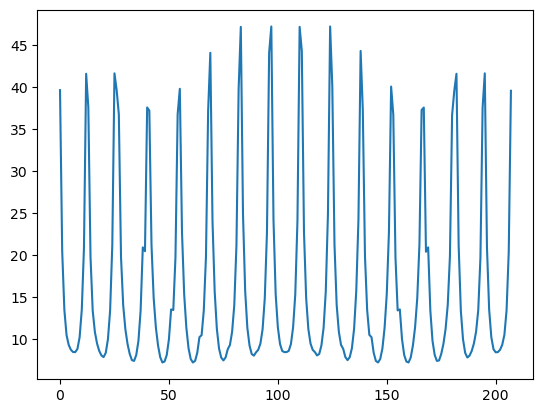

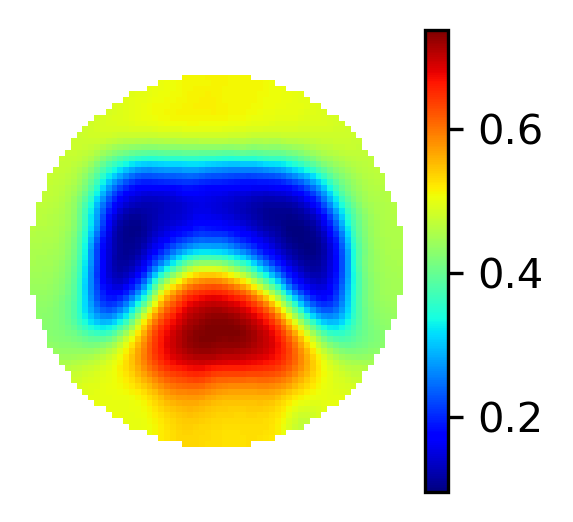

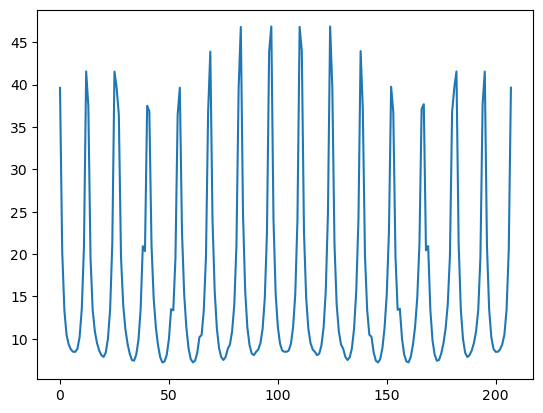

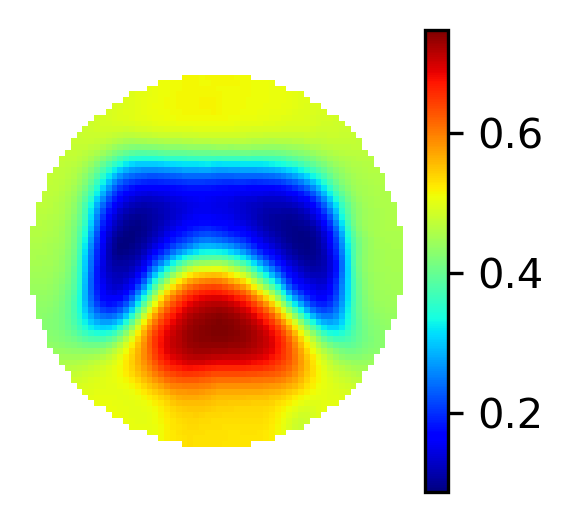

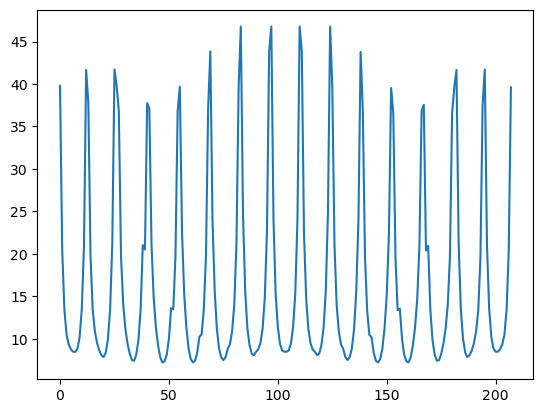

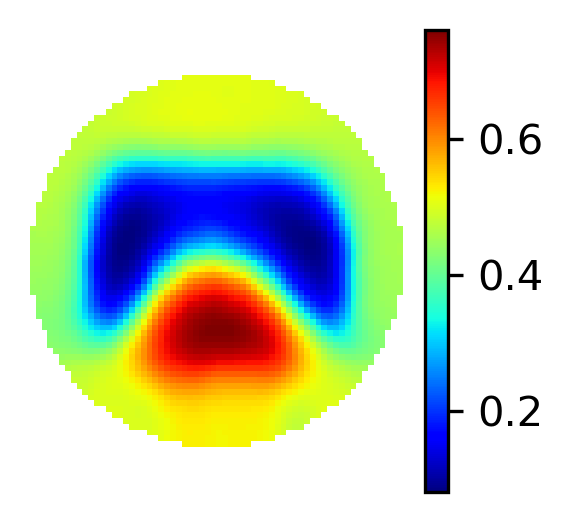

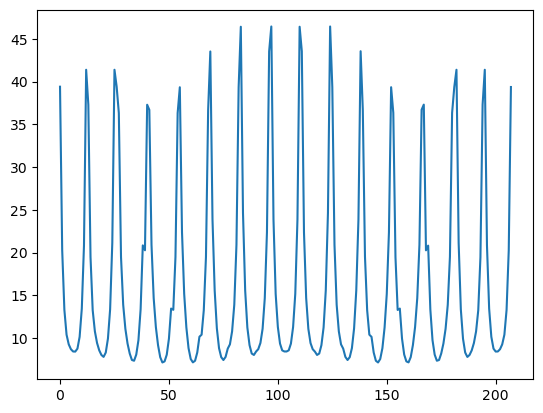

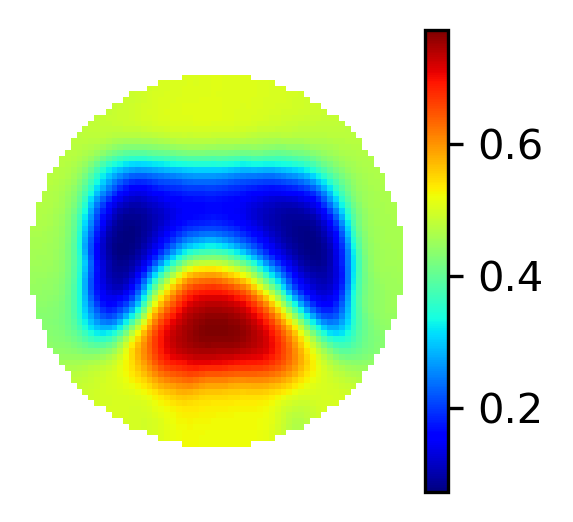

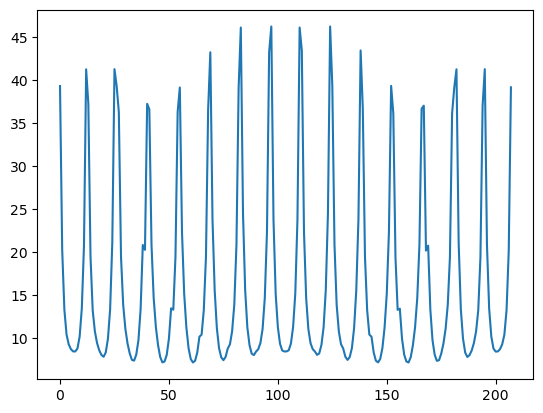

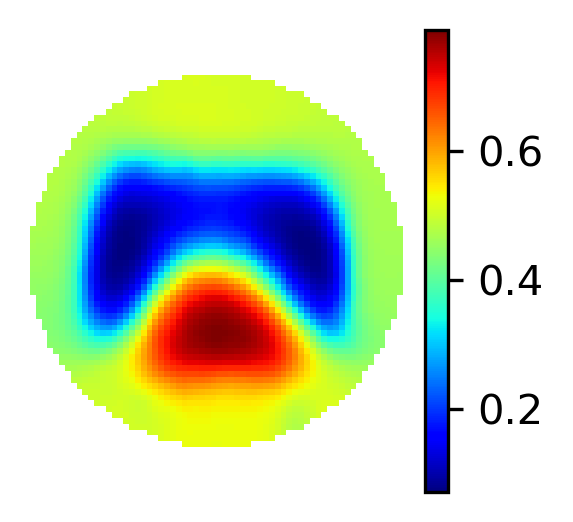

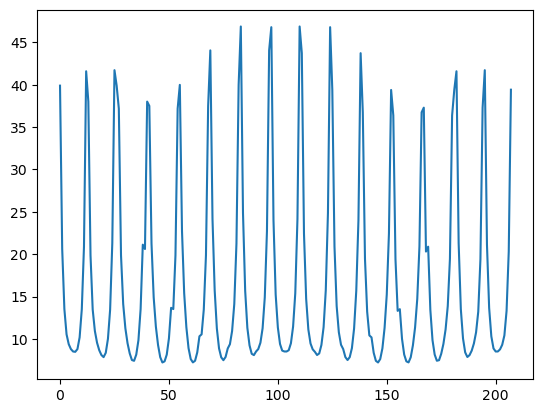

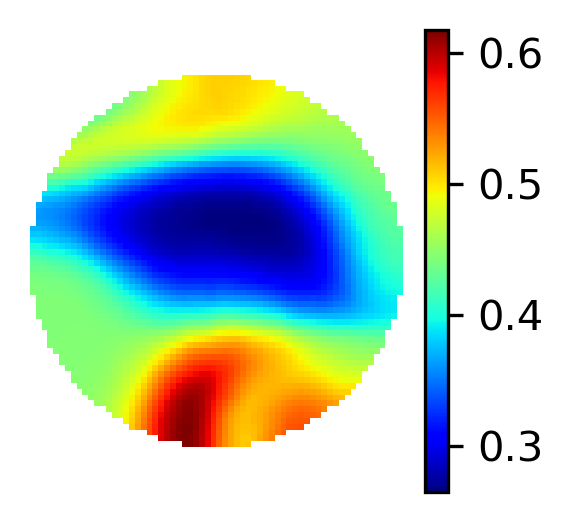

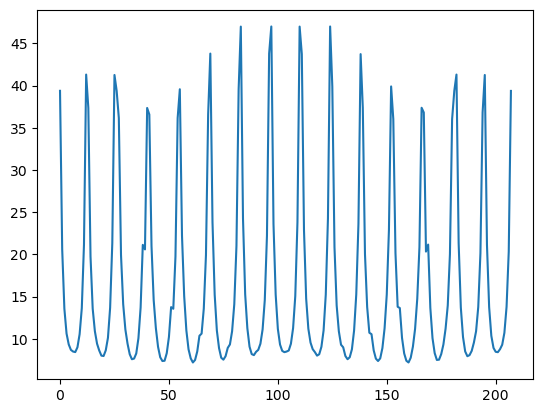

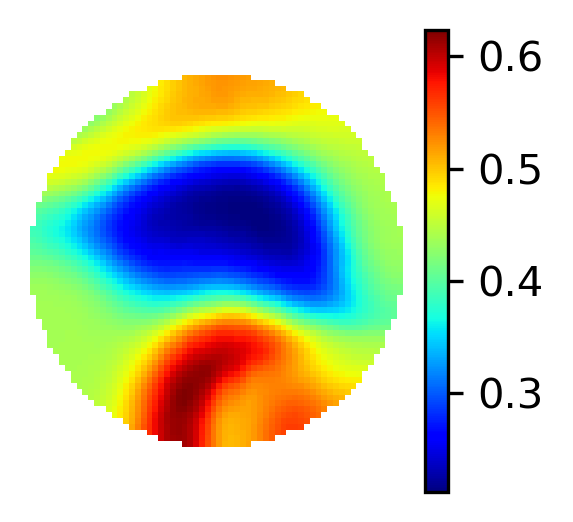

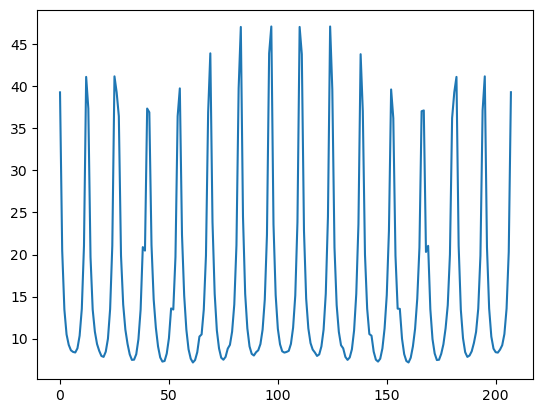

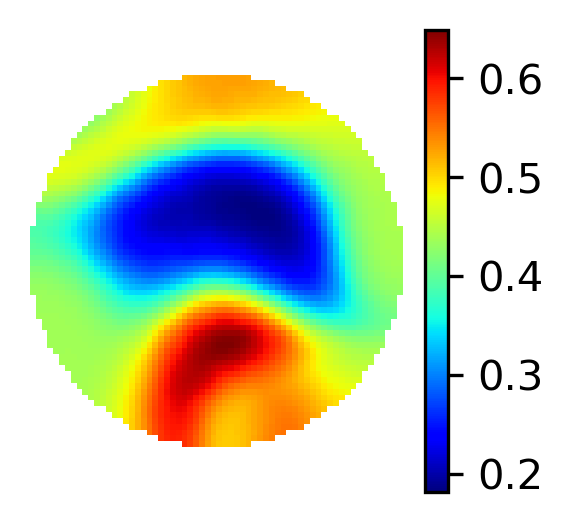

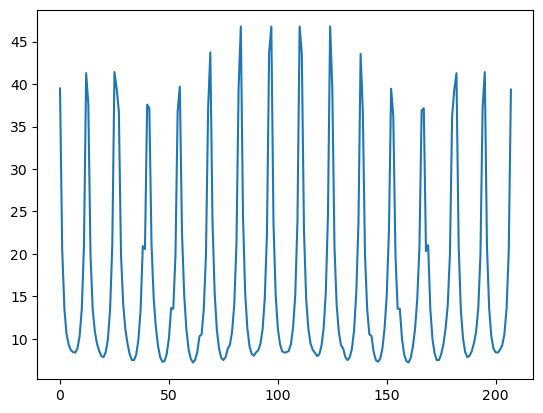

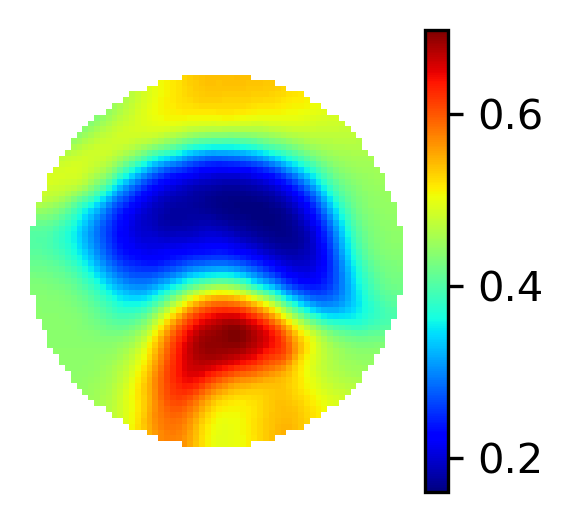

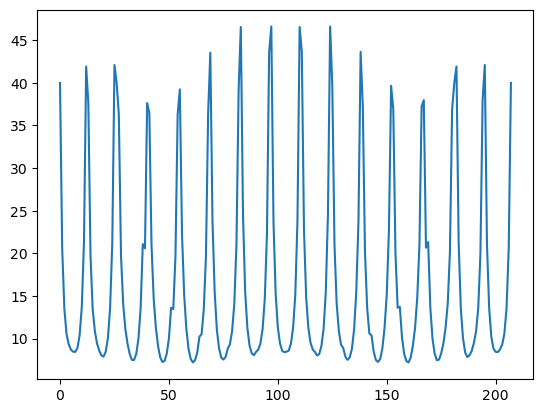

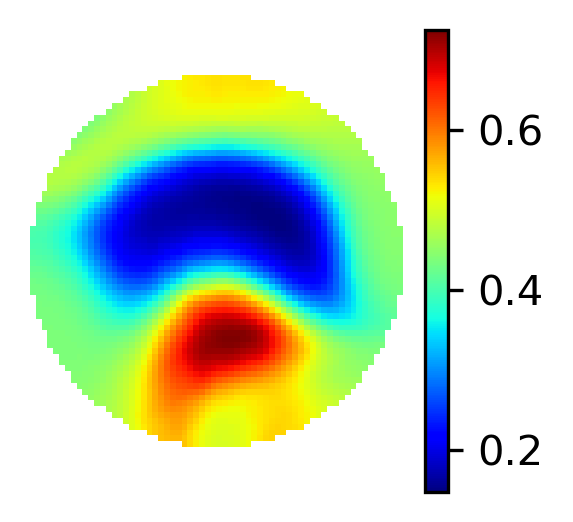

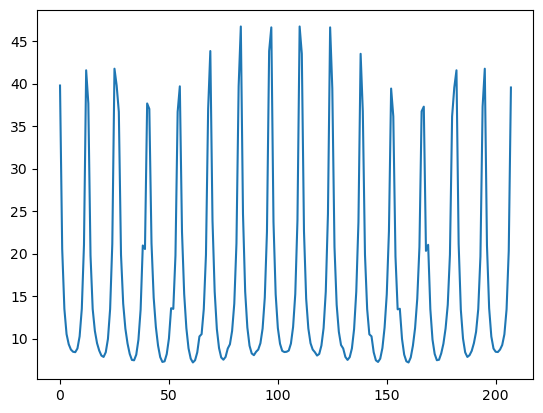

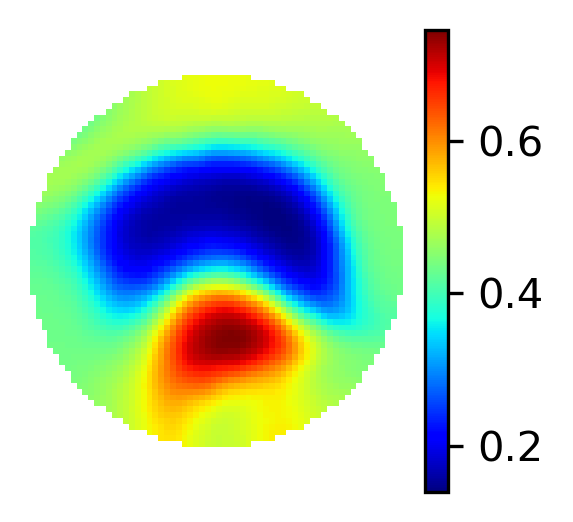

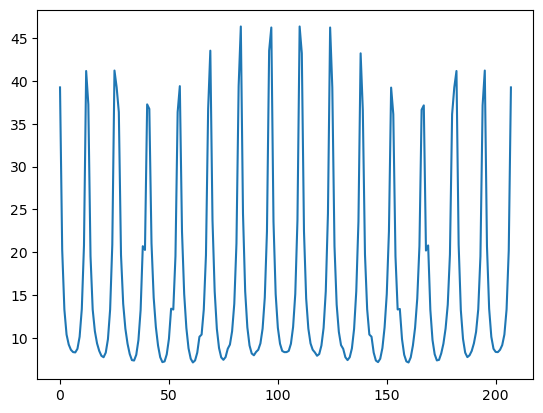

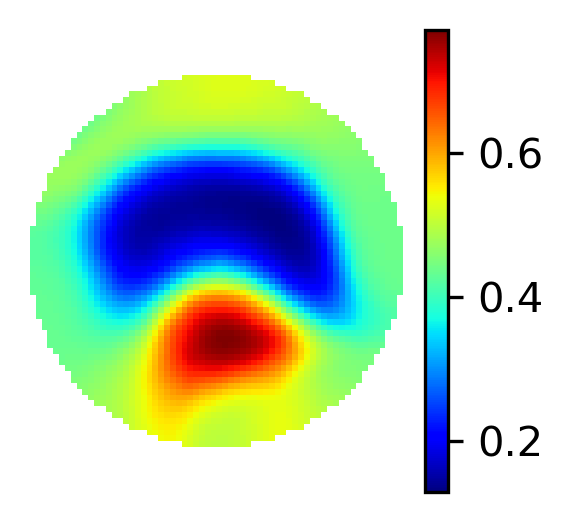

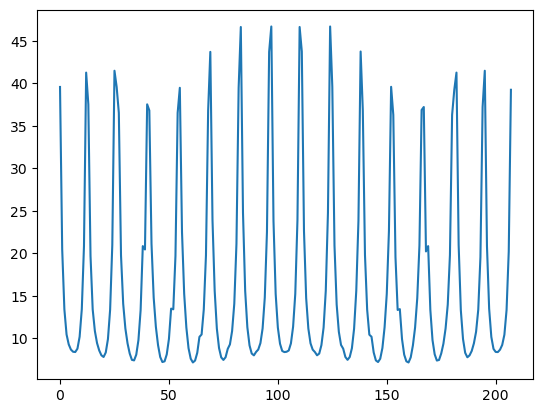

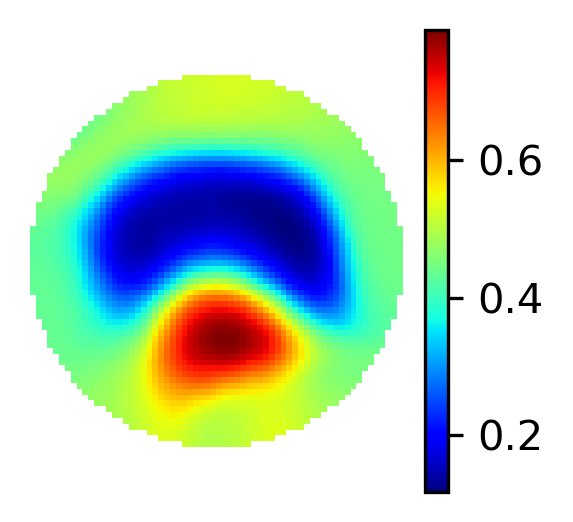

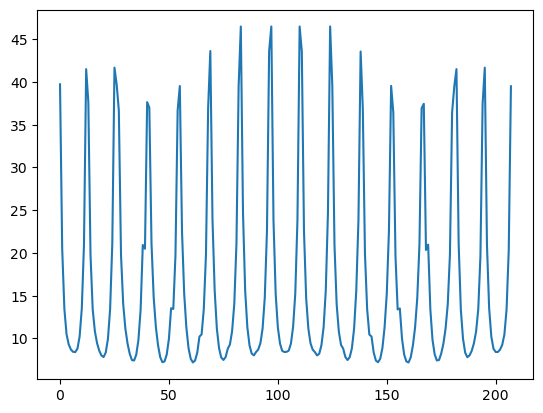

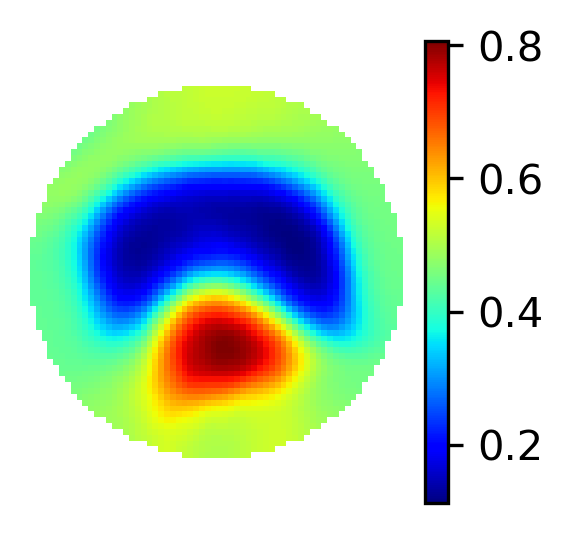

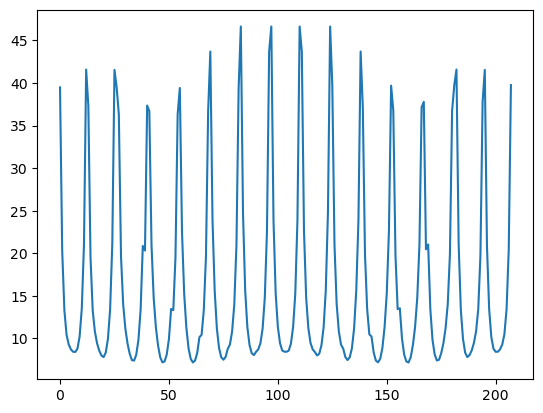

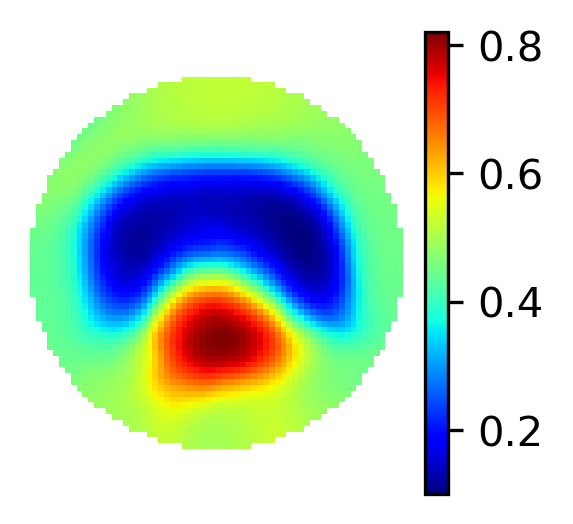

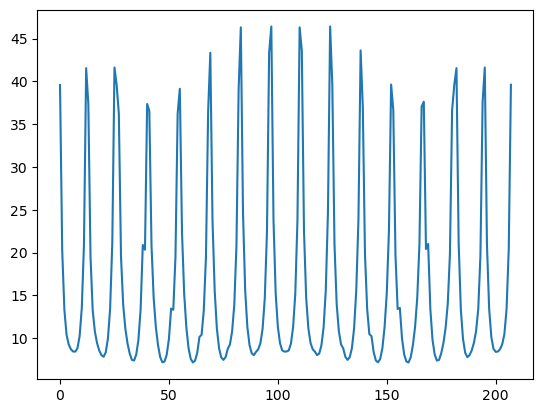

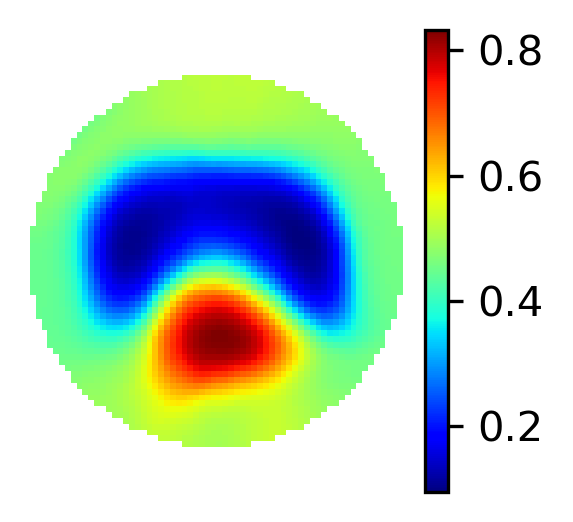

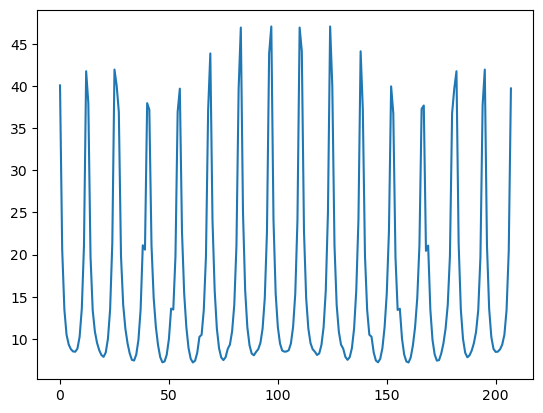

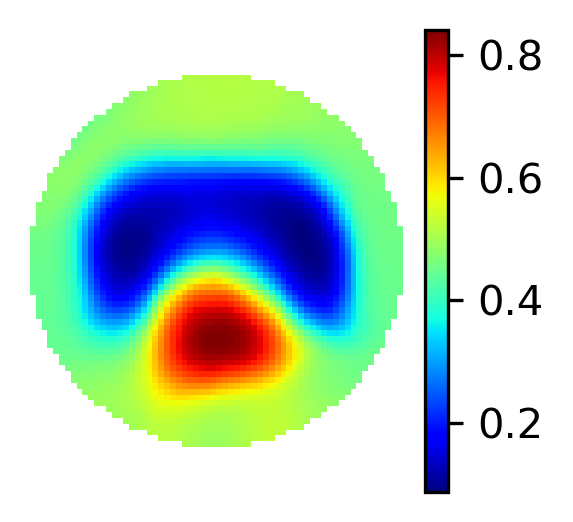

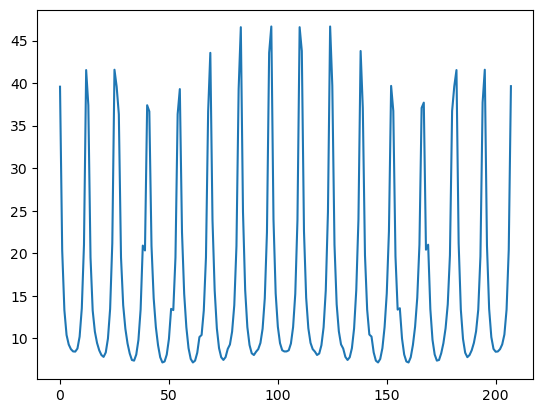

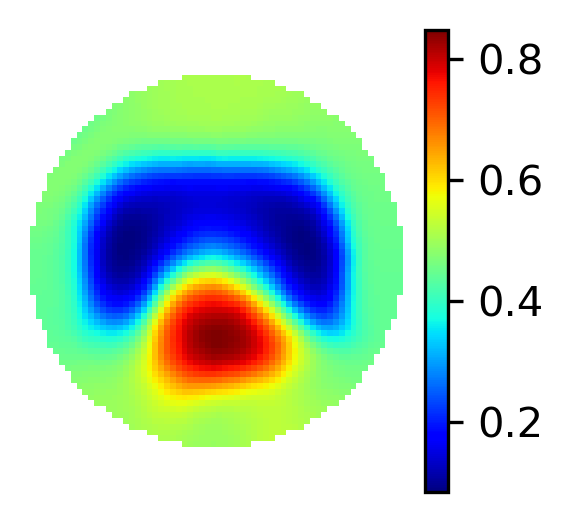

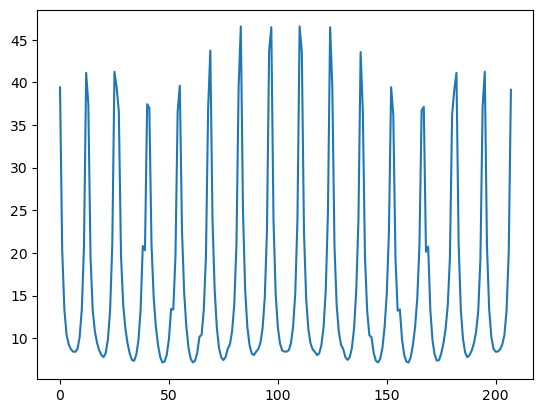

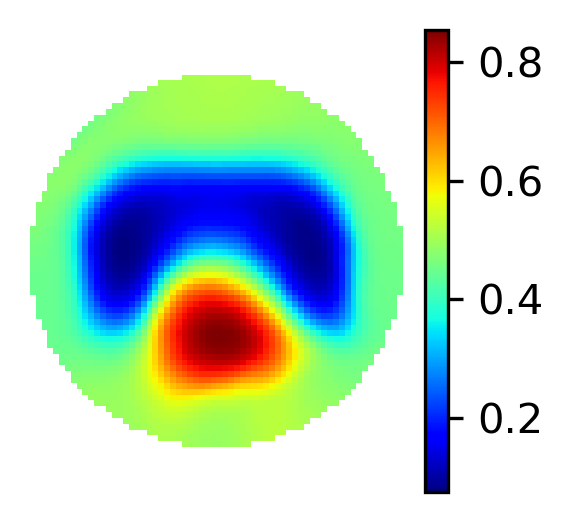

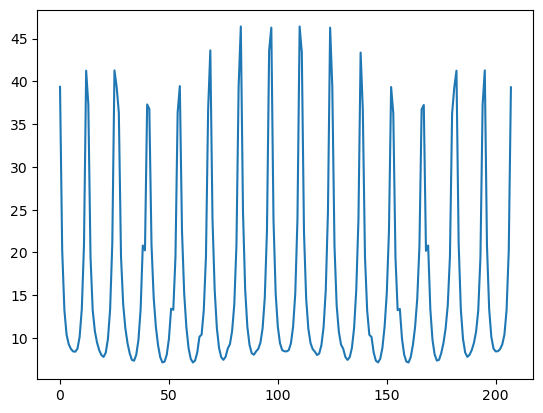

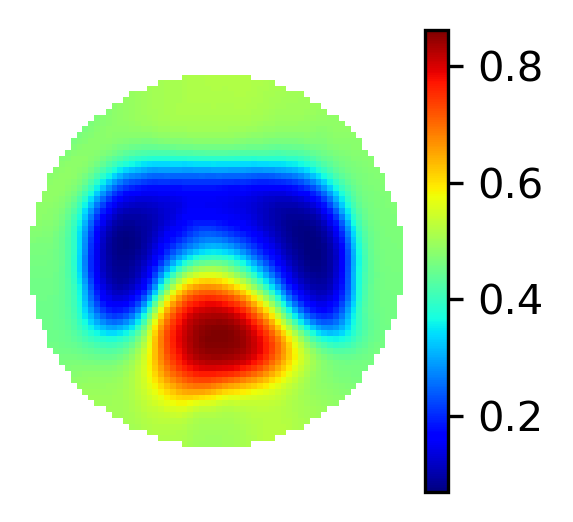

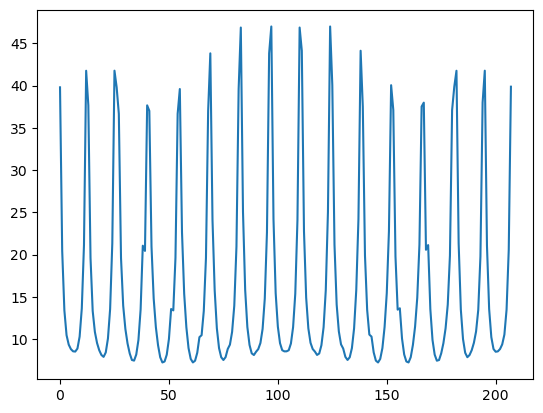

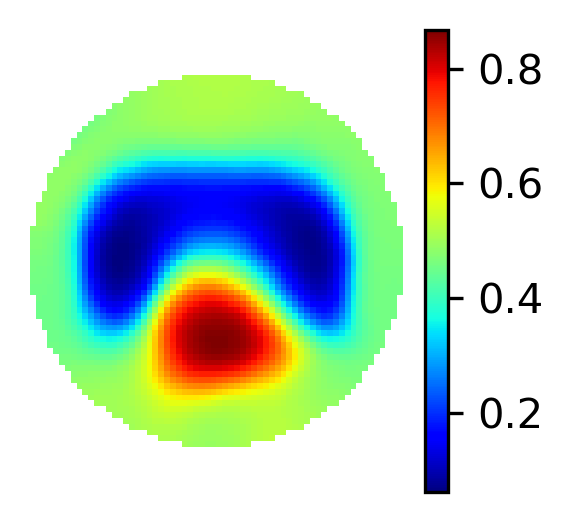

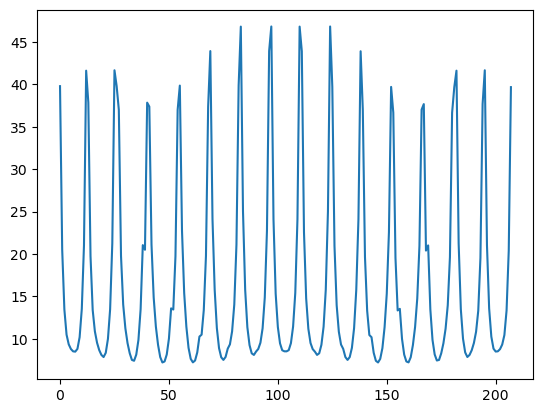

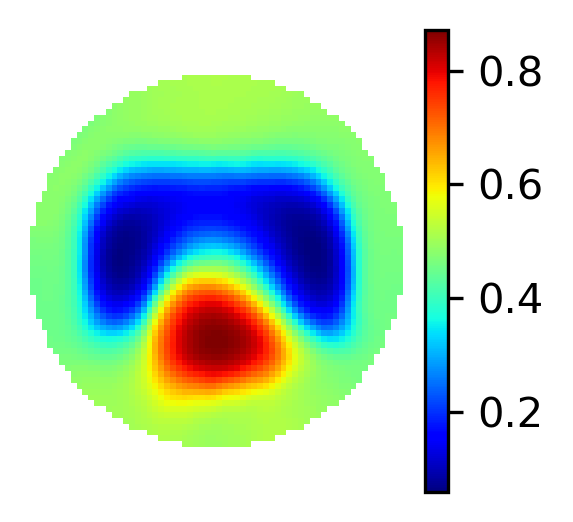

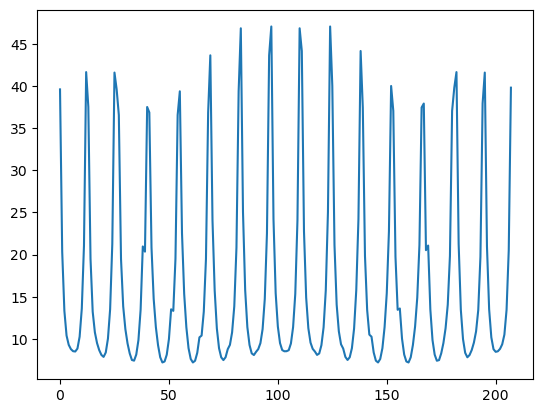

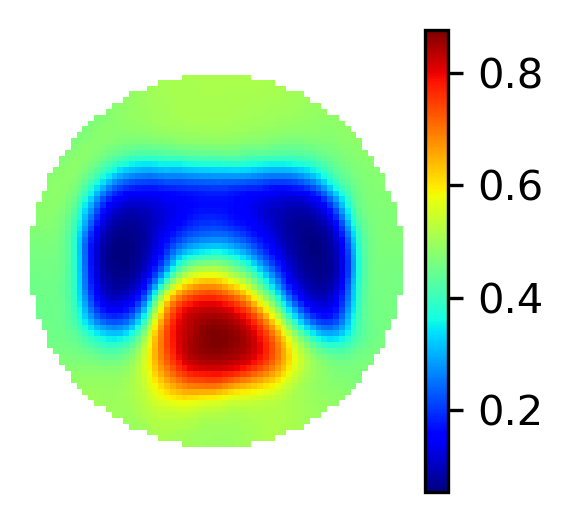

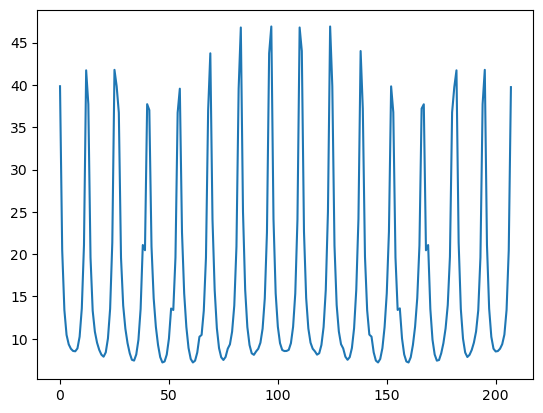

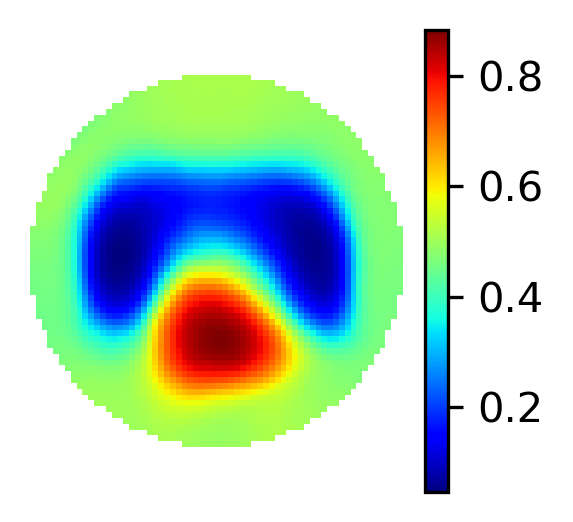

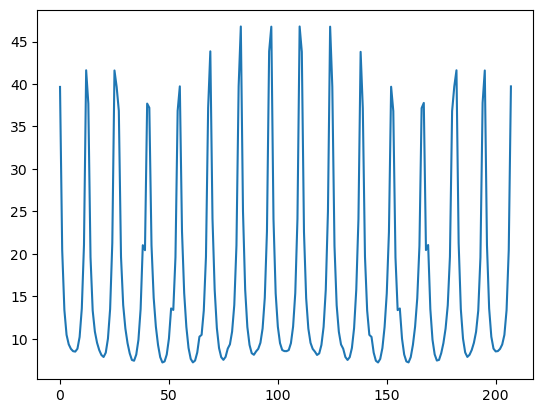

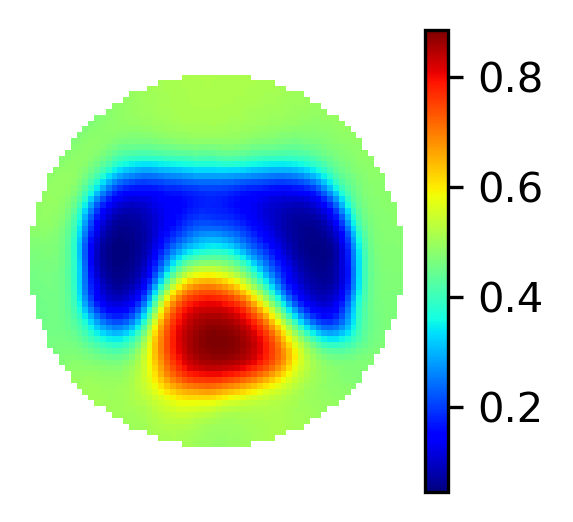

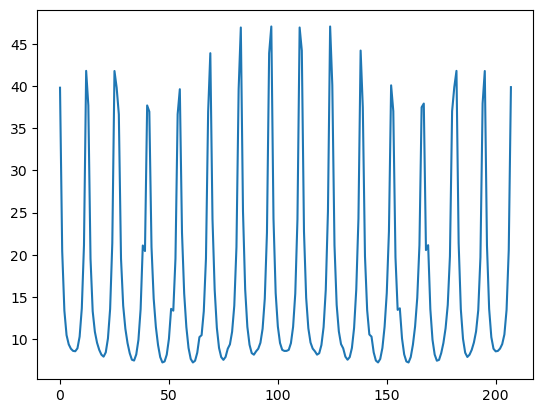

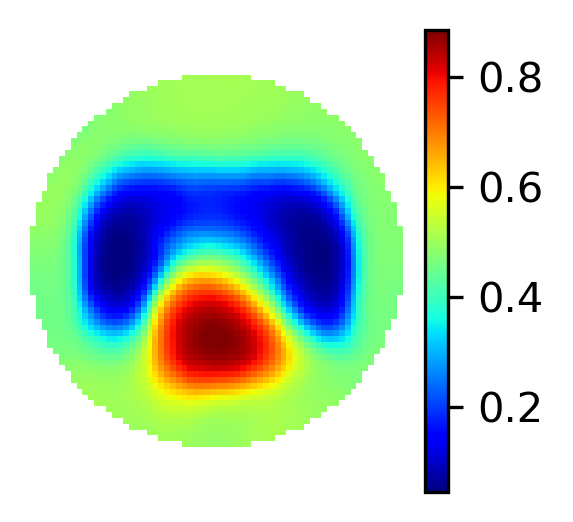

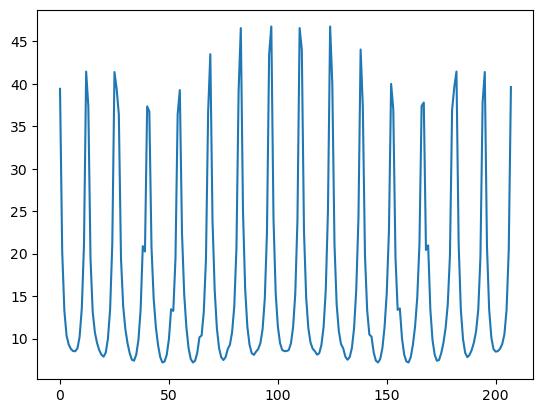

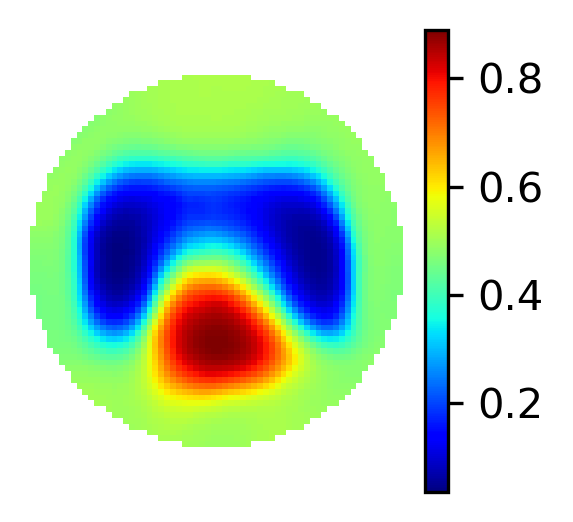

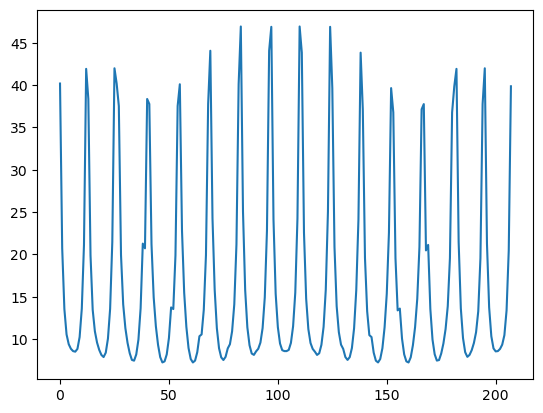

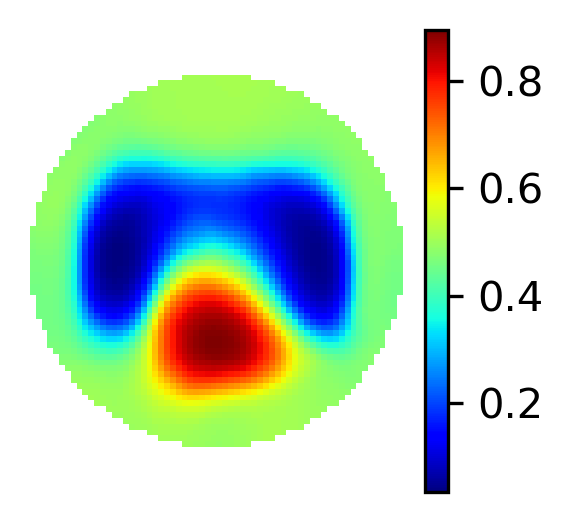

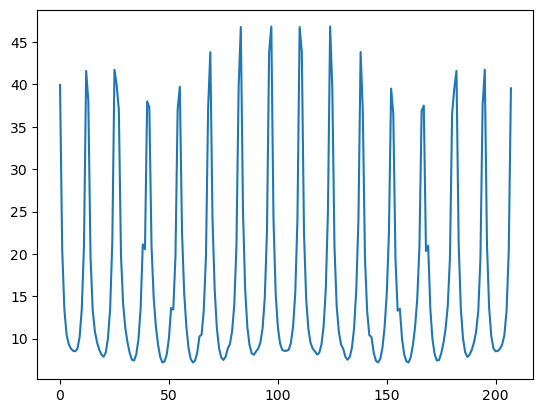

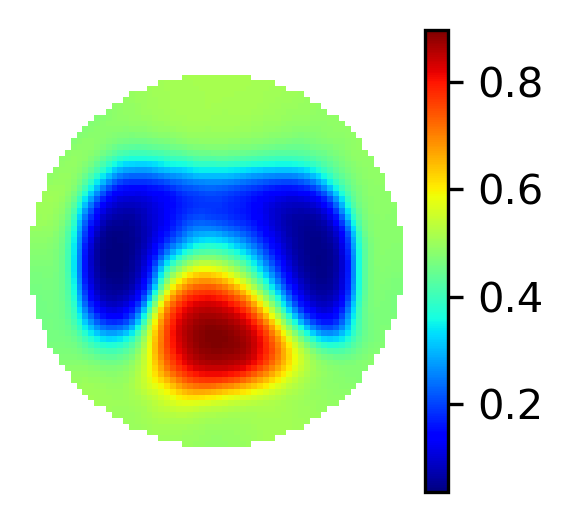

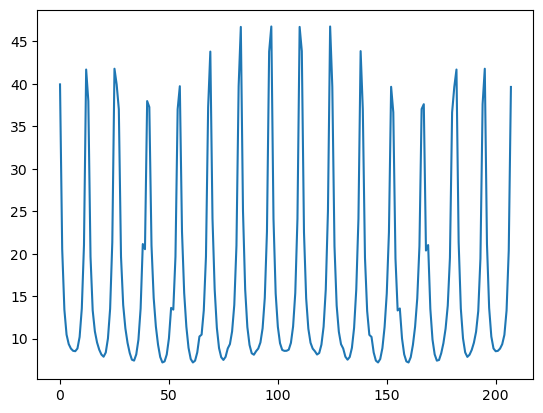

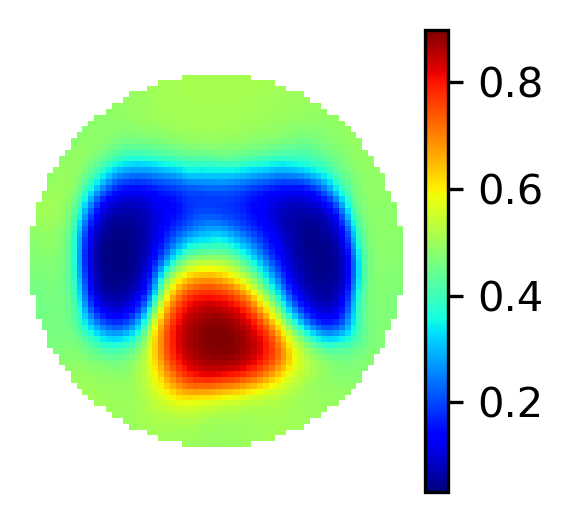

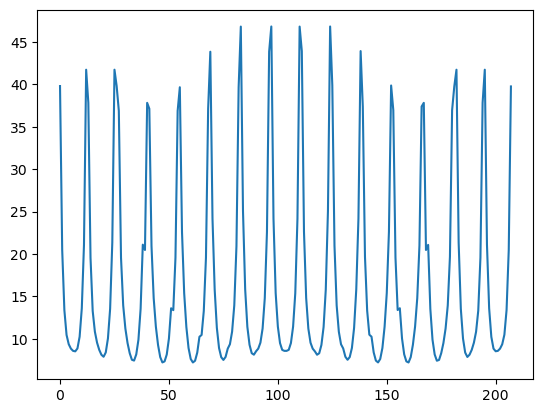

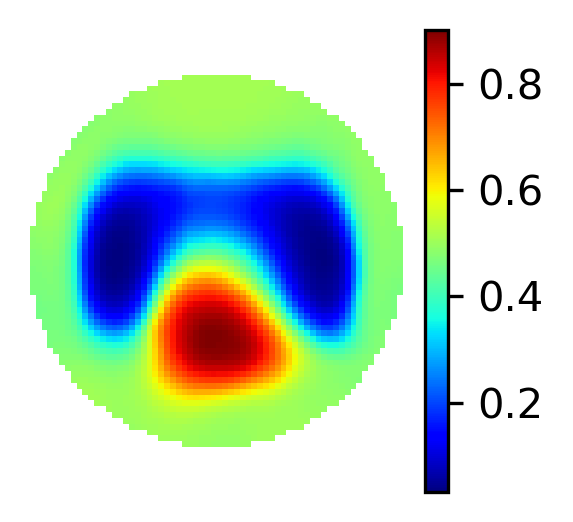

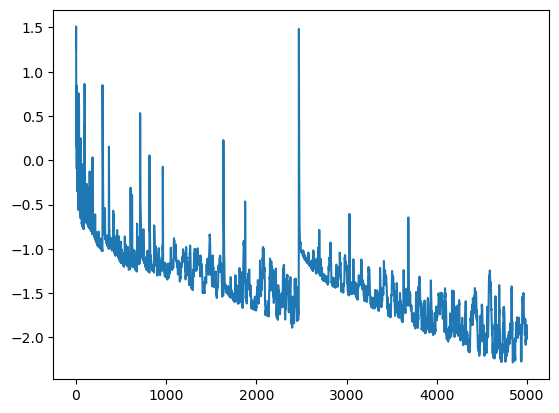

In [ ]:
#random noise
z = torch.zeros([1, 1, 64, 64])
z.uniform_()
z *= 1./15  
LR = 0.005 # learning rate


# z=img_noisy_torch.detach().clone()
# z = torch.reshape(z,[1, 1, 64, 64])

net_input=z.type(dtype).detach()
print (net_input.shape)
print (net_input)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./25. 

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

imsize =-1
PLOT = True
# sigma = 25
# sigma_ = sigma/255.
figsize = 4 
num_iter = 5000
L_eit=[]


plt.figure(dpi=100)
plt.plot( np.linspace(0, 207, 208),dV.detach().cpu().numpy())
# plt.axis('off') 
plt.show()


i = 0
p = get_params(OPT_OVER, net, net_input)
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(p, lr=LR) # Adam SGD  Adadelta LBFGS
theta = [param for param in net.parameters()]

for j in range(num_iter):
    optimizer.zero_grad()

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)
    # print(out)         
    
    sigma_out_t=out.clone().detach().requires_grad_(True)
    sigma_out_t = torch.reshape(sigma_out_t, (64, 64))
    sig=P(sigma_out_t.t().flatten() , PM)
    U_value = U(sig,J)
    total_loss = mse(U_value, dV)

    # print(U_value.shape)
    # print(V.shape)

    L_eit.append(np.log10(total_loss.item()))
    # total_loss.backward()

    with torch.no_grad():
        # Compute ∂L/∂σout
        dL_dsigma = 2 *torch.matmul(J.t(),U_value - dV)/208 #Except for 208, because the loss above used the standard deviation, it is necessary to calculate the average.
        # dL_dsigma = torch.autograd.grad(total_loss, sig, retain_graph=True)[0] #equivalent

        dL_dsigma1=torch.matmul(dL_dsigma,PM)
        dL_dsigma1=torch.reshape(dL_dsigma1,[64,64]).T  #At first, sig was transposed. Here, it needs to be transposed back again.
        dL_dsigma1=torch.reshape(dL_dsigma1,[1,1,64,64])
        
        dL_dtheta = torch.autograd.grad(out, p, grad_outputs=dL_dsigma1, retain_graph=True)

    # Use the new gradient to update the model parameters.
    with torch.no_grad():
        for param, grad in zip(theta, dL_dtheta):
            param -= LR * grad

    psrn_noisy = compare_psnr(img_noisy_np, np.reshape(out.detach().cpu().numpy(),[64, 64])) 
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f  ' % (i, total_loss.item(), psrn_noisy), '\r', end='')

    if  PLOT and i % show_every == 0:
        Image_plot(torch.mul(torch.reshape(out,[64,64]),tranp))
        plt.figure(dpi=100)
        plt.plot( np.linspace(0, 207, 208),U_value.detach().cpu().numpy())
        # plt.axis('off') 
        plt.show()

    optimizer.step()   
    # optimizer.zero_grad()
    i += 1
#-------------------------------------------
out_np = net(net_input)
out_np=torch.reshape(out_np,[64,64])
# print(out_np)
Image_plot(torch.mul(out_np,tranp))

plt.figure(dpi=100)
plt.plot( np.linspace(0, num_iter-1, num_iter),L_eit)
# plt.axis('off') 
plt.show()

savemat("Demo_Case1_UNNP.mat", {"ZZ":out_np.detach().cpu().numpy()})